# LSTM Single Model

---

In [2]:
# DataFrame
import pandas as pd
import numpy as np
import random

# Date
from datetime import datetime, date
import matplotlib.dates as mdates

# Preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Visualization
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# Save the log
import os
import time
import pickle 
import re
import warnings

# Lasso
from sklearn.linear_model import Lasso

# LSTM
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MSE

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Optimization
from keras_tuner.tuners import RandomSearch

import tempfile

# Metric 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score

In [7]:
df = pd.read_csv("../Data/All_capstone_df.csv")
df['Date'] = pd.to_datetime(df['Date'])

In [8]:
# Minus
matplotlib.rcParams['axes.unicode_minus'] = False
# 한글
plt.rcParams['font.family'] = 'Malgun Gothic'

---

### Split the train and test set
- Input
     data: dataframe with dates and Demand data
     
- output
    - train: ~ 2012-06-30
    
    - test :  2022-07-01 ~ 2012-12-31

In [107]:
def lasso_feature_selection(df):
    tmp_df = df.drop(columns=['Date','Product', '년월'])
    # 데이터프레임에서 y값 열 추출
    y = tmp_df.loc[:, 'y']
    
    # 데이터프레임에서 y값 열을 제외한 나머지 열을 X로 설정
    X = tmp_df.drop(columns='y')
    
    # Lasso 회귀 모델 생성
    lasso = Lasso(alpha=10)  # alpha 값을 조절하여 정규화 강도 조절 가능
    
    # 모델 훈련
    lasso.fit(X, y)
    
    # 각 변수의 계수 출력
    coefficients = pd.Series(lasso.coef_, index=X.columns)
    print("각 변수의 계수:")
    print(coefficients)
    
    # 선택된 변수만 보여주기
    selected_var = coefficients[coefficients != 0]
    print("\n선택된 변수:")
    print(selected_var)
    
    return selected_var.index.tolist()

In [139]:
def split_data(product_df, time_steps): 
    
    train_end = len(product_df[product_df['Date']<'2022-07-01'])
    
    # Feature selection using Lasso
    selected_features = lasso_feature_selection(product_df)
    #selected_features += ['y'] # 종속변수 추가
    selected_features.insert(0, 'y')
    # global var 설정 
    global n_features
    n_features = len(selected_features)
    target_idx = selected_features.index('y')
    
    filtered_df = product_df.filter(selected_features)  # 다변량 features
    sc = MinMaxScaler() 
    ## Train set 
    y_train_scaled = sc.fit_transform(filtered_df.iloc[:train_end, :])
    
    X_train = [] 
    y_train = []
    for i in range(time_steps, train_end):
        X_train.append(y_train_scaled[i-time_steps:i, :])  # 여러 feature들의 time steps 만큼의 데이터
        y_train.append(y_train_scaled[i, target_idx])  # target 변수 (예: 'y')
        
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], n_features))  # feature 개수를 반영
    
    ## Test set 
    y_test_scaled = sc.transform(filtered_df.iloc[train_end:, :])
    
    X_test = []
    y_test = product_df.iloc[train_end+time_steps:].copy()
    y_test['y_norm'] = y_test_scaled[time_steps:, target_idx]  
    
    for i in range(time_steps, len(y_test_scaled)):
        X_test.append(y_test_scaled[i-time_steps:i, :])
    
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], n_features))

    return X_train, y_train, X_test, y_test, sc, target_idx

### LSTM

### Optimize Parameters using Keras Tuner
    - (Random search)

In [140]:
def build_model(hp):
    model = Sequential()
    # 2개의 LSTM Layers
    model.add(LSTM(units=hp.Int('units_1', min_value=256, max_value=320, step=64),
                   activation='tanh',
                   return_sequences=True, 
                   input_shape=(None, n_features)))
    
    model.add(LSTM(units=hp.Int('units_2', min_value=128, max_value=256, step=32),
                   activation='tanh',
                   return_sequences=False))

    model.add(Dense(units=hp.Int('dense_unit', min_value=16, max_value=128, step=16),
                    activation='tanh'))
        
    model.add(Dense(1))

    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss='mean_squared_error',
                  metrics=['mae'])

    return model

def optimize_model(X_train, y_train, X_test, sc, epochs, trials, targer_idx):
    # 진행 상황 저장 할 필요없어서, 임시 경로 생성
    with tempfile.TemporaryDirectory() as temp_dir:
        tuner = RandomSearch(
            build_model,
            objective='loss',
            max_trials= trials,
            directory=temp_dir,
            project_name='temp_project')

    tuner.search_space_summary()

    # 최적의 조합 탐색
    tuner.search(X_train, 
                 y_train,
                 epochs=epochs,
                 batch_size=8)

    tuner.results_summary()

    best_model = tuner.get_best_models(num_models=1)[0]

    # Test 데이터 예측값
    pred = best_model.predict(X_test) # 예측값 얻기
    pred_norm = pred # normalize predicted
    
    pred_expanded = np.zeros((pred.shape[0], n_features))
    pred_expanded[:,targer_idx] = pred.ravel()  # 첫 번째 feature에 pred 값을 채움
    
    # inverse_transform 적용
    pred = sc.inverse_transform(pred_expanded)
    pred = pred[:,targer_idx]  # 원하는 첫 번째 feature만 선택

    best_model.summary()
    # 모델 객체와 예측값 반환
    return best_model, pred, pred_norm

### LSTM Single Model

In [141]:
def LSTM_single(product_code, product_df, time_steps, epochs, trials):

    # 학습 데이터와 테스트 데이터 분리
    X_train, y_train, X_test, y_test, sc, target_idx = split_data(product_df, time_steps)
    
    #best_model, pred, pred_norm = use_saved_model(X_test, product_code, '0925')
    # LSTM 모델 학습 및 예측
    best_model, pred, pred_norm = optimize_model(X_train, y_train, X_test, sc, epochs, trials, target_idx)
    
    # 예측 결과 저장
    y_test.reset_index(drop=True, inplace=True)
    pred_df = pd.DataFrame({'Pred': pred.reshape(-1) ,'Pred_norm': pred_norm.reshape(-1)})
    res_df = pd.concat([y_test, pred_df], axis=1)
    res_df.set_index('Date', inplace=True)
    res_df.loc[res_df['Pred']<0, 'Pred']=0
    # res_df: ['y', 'y_norm', 'Pred', 'Pred_norm'], index='Date'
        
    # 모델과 result_df
    return best_model, res_df

## Plot the result

In [142]:
def actual_pred_plot(product_code, res_df, metric_df):
    today = date.today()
    """
    Plot the actual vs predition and save the figure in the given directory
    """
    res_df.index = pd.to_datetime(res_df.index)
    save_path = os.path.join("Result", "Lasso+LSTM_Result", product_code)
    save_name = f'{product_code}_all_result'
    
    title = f"Pred Actual Plot - {product_code}"
    actual = res_df['y']
    pred = res_df['Pred']

    # Plot   
    plt.figure(figsize=(16, 8))
    plt.title(title, fontsize=20)
    plt.xlabel("Date", fontsize=14)
    plt.ylabel("Order Demand", fontsize=14)

    plt.plot(res_df.index, actual, label ='Actual', color='r', marker='o', ms=3)
    plt.plot(res_df.index, pred, label='Prediction',color='b', marker='o', ms=3)
    
    # x축의 주요 틱 위치를 매 월 첫날로 설정하고, 라벨을 해당 월로 표시
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.legend(loc="upper right")
    
    # Plot 결과 저장
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    # save the figure
    today_date = f'_{today.month:02d}{today.day:02d}'
    plt.savefig(os.path.join(save_path, save_name+today_date+'.png'))
    plt.show()
    # Metric도 함께 저장
    metric_df.to_csv(os.path.join(save_path, save_name+today_date+'.csv'), encoding="utf-8-sig")
        
    plt.close('all') # close all figures to free up memory

## Save and Load the model 

In [143]:
def save_model(product_code, best_model):
    today = date.today()
    folder_path = 'Result/Lasso+LSTM_Result/Model'
    file_name = f'{product_code}_{today.month:02d}{today.day:02d}.pkl'
    save_path = os.path.join(folder_path, file_name)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    # 객체를 pickle 파일로 저장
    with open(save_path, 'wb') as f:
        pickle.dump(best_model, f)
    return best_model

In [144]:
def load_model(product_code, date):
    file_path = f'Result/Lasso+LSTM_Result/Model/{product_code}_{date}.pkl'
    
    with open(file_path, 'rb') as file:
        model_dict= pickle.load(file)
    
    return best_model

In [145]:
def use_saved_model(X_test, product_code, date):
    # 모델 파일 경로
    model_path = f'Result/Lasso+LSTM_Result/Model/{product_code}_{date}.pkl'
    
    # 모델 로드
    with open(model_path, 'rb') as file:
        best_model = pickle.load(file)
    best_model.summary()

    # Test 데이터 예측값
    pred = best_model.predict(X_test) # 예측값 얻기
    pred_norm = pred # normalize predicted
    
    pred_expanded = np.zeros((pred.shape[0], n_features))
    pred_expanded[:,0] = pred.ravel()  # 첫 번째 feature에 pred 값을 채움
    
    # inverse_transform 적용
    pred = sc.inverse_transform(pred_expanded)
    pred = pred[:, 0]  # 원하는 첫 번째 feature만 선택
    
    best_model.summary()
    # 모델 객체와 예측값 반환
    return best_model, pred, pred_norm

## Metrics

In [146]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / (actual+1)))

# 정규화 된 지표
def nrmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred, squared=False)
    target_mean = np.mean(y_true)
    nrmse = mse / target_mean
    return nrmse

# 정규화 된 지표
def nmae(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    target_mean = np.mean(y_true)
    nmae = mae / target_mean
    return nmae

In [147]:
def calculate_metrics(product_code, res_df):
  
    actual = res_df['y']
    pred = res_df['Pred']

    # 메트릭 계산
    MAPE = mape(actual, pred) 
    RMSE = mean_squared_error(actual, pred)**0.5 
    MAE = mean_absolute_error(actual,pred) 
    NRMSE = nrmse(actual,pred) 
    NMAE = nmae(actual,pred)
    R2 = r2_score(actual,pred) 

    # 계산된 메트릭을 데이터프레임에 추가
    metric_df = pd.DataFrame({'MAPE':[round(MAPE, 4)],
                           'RMSE':[round(RMSE, 4)],
                           'MAE':[round(MAE, 4)],
                           'NRMSE':[round(NRMSE, 4)],
                           'NMAE':[round(NMAE, 4)],
                           'R2':[round(R2, 4)]},
                            index= [product_code])

    return metric_df

---

## Check the Result

In [148]:
def execute_single_LSTM(product_code, time_steps=10, epochs=30, trials=1):
    
    start_time = time.time()

    product_df = df[df['Product']== product_code].reset_index(drop=True)
    
    # LSTM 단일 모델
    model, res_df = LSTM_single(product_code, product_df, time_steps, epochs, trials) #dictionary, time_steps, epochs
    print(res_df)
    save_model(product_code, model)
    
    # 모델 Metric과 Pred_Actual Plot 저장
    metric_df = calculate_metrics(product_code, res_df)
    actual_pred_plot(product_code, res_df, metric_df)
    
    # 실행시간 확인
    elapsed_time_seconds = time.time() - start_time
    elapsed_time_minutes = elapsed_time_seconds / 60
    print("실행 시간: {:.2f} 분".format(elapsed_time_minutes))
    return metric_df

---

## Whole Process
    - product_code에 str으로 예측하고자 하는 코드를 입력

In [149]:
for product in df['Product'].unique():
    print("==================================")
    print(f"========== { product } ==========")
    print("==================================")
    execute_single_LSTM(product)

========== 가나칸정 ==========
각 변수의 계수:
월                        0.000000
일                       -2.248791
요일                     -23.275763
공휴일여부                   -0.000000
소비자물가지수(2020＝100)_전국    -0.000000
기업경기실사지수(실적)_제 조 업      -0.130211
기업경기실사지수(전망)_제 조 업       0.000000
경제심리지수_경제심리지수(순환변동치)     0.000000
경제심리지수_경제심리지수(원계열)       0.439990
설비투자지수_총지수              -0.000000
수입물가지수(기본분류)_총지수        -0.193865
수출물가지수(기본분류)_총지수         0.000000
평균기온(°C)                -0.125930
일강수량(mm)                -0.054255
평균 풍속(m/s)               0.000000
dtype: float64

선택된 변수:
월                       0.0
공휴일여부                  -0.0
소비자물가지수(2020＝100)_전국   -0.0
기업경기실사지수(전망)_제 조 업      0.0
경제심리지수_경제심리지수(순환변동치)    0.0
설비투자지수_총지수             -0.0
수출물가지수(기본분류)_총지수        0.0
평균 풍속(m/s)              0.0
dtype: float64
Search space summary
Default search space size: 4
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 256, 'max_value': 320, 'step': 64, 'sampling': 'linear'}
units_2 (Int)
{'defa

KeyboardInterrupt: 

Trial 1 Complete [00h 02m 44s]
loss: 0.033006779849529266

Best loss So Far: 0.033006779849529266
Total elapsed time: 00h 02m 44s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Results summary
Results in C:\Users\7info\AppData\Local\Temp\tmp8z5wn9gn\temp_project
Showing 10 best trials
Objective(name="loss", direction="min")

Trial 0 summary
Hyperparameters:
units_1: 256
units_2: 128
dense_unit: 32
learning_rate: 0.01
Score: 0.033006779849529266
6/6 [==============================] - 1s 10ms/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 256)         272384    
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                              

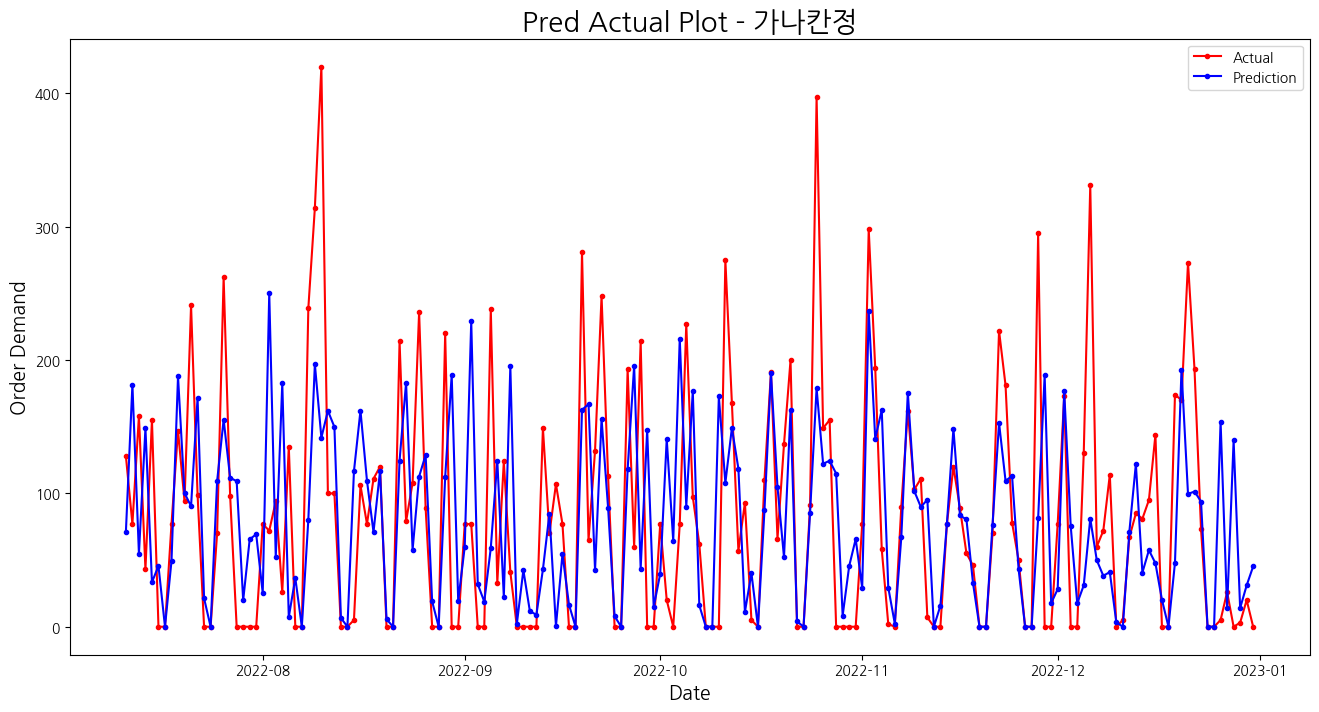

실행 시간: 2.77 분


,MAPE,RMSE,MAE,NRMSE,NMAE,R2
가나칸정,11.8385,83.2665,58.9454,1.0131,0.7172,0.1527


In [150]:
execute_single_LSTM('가나칸정')